In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import sys, os, random
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import scanpy as sc
import statsmodels.api as sm
from scipy import sparse
import anndata as ad
from scipy.stats import nbinom
from scipy.special import gamma
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from scipy.special import gamma, loggamma, gammaln
import itertools
import warnings
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from tqdm import tqdm
import numpy.matlib
warnings.filterwarnings("ignore")
plt.style.use('seaborn-white')
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

#R interface
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri
# import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
# from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import xgboost as xgb

In [25]:
# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
# sc.logging.print_versions()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [27]:
%%R
library(Seurat)
library(scDblFinder)
library(SingleCellExperiment)

In [4]:
def roc_pr_plot(y_label, y_pre ,path=None, title=None):
    print(type(y_label), type(y_pre))
    precision, recall, thresholds_pr = precision_recall_curve(y_label, y_pre)
    fpr, tpr, thersholds_roc = roc_curve(y_label, y_pre, pos_label=1)
    pr_auc = auc(recall, precision)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(fpr, tpr, 'r--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
     
    ax.set_xlim([0, 1.05])  
    ax.set_ylim([0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')  
    ax.set_title('ROC Curve - {}'.format(title))
    ax.legend(loc="center right")
    ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='-',c='b', lw=0.5)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(recall, precision, 'r--', label='PR (area = {0:.2f})'.format(pr_auc), lw=2)
     
    ax2.set_xlim([0, 1.05])  
    ax2.set_ylim([0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision') 
    ax2.set_title('PR Curve - {}'.format(title))
    ax2.legend(loc="center right")
    ax2.plot((0, 1), (1, 0), transform=ax2.transAxes, ls='-',c='b', lw=0.5)
    if path:
        fig.savefig(path)

In [5]:
# NB model
def func_fit(x, a):
    return a* x
def NB_pre(this_mtx, CURVE_FIT=True):
    all_miu = np.mean(this_mtx, axis=0)
    all_var = np.var(this_mtx, axis=0)
    # curve fitting
    X1 = (all_var-all_miu)
    Y1 = np.power(all_miu, 2)
    popt, _ = curve_fit(func_fit, X1, Y1)
    all_theta = np.repeat(popt, this_mtx.shape[1])
    return all_miu, all_var, all_theta

def NB_model(y, theta, miu):
    eps = 1e-10
    #! log(0) -> nan
    log_t1 = theta * (np.log(theta+eps) - np.log(theta+miu+eps))
    log_t2 = y * (np.log(miu+eps) - np.log(miu+theta+eps))
    log_t3 = gammaln(y+theta+eps) - gammaln(y+1+eps) - gammaln(theta+eps)
    #! log(0) -> nan
    results =log_t1 + log_t2 + log_t3
    return results

def generate_classify_param(score_lst, rank_lst=[1, 2]):
    rank_a, rank_b = rank_lst
    max_idxa, max_idxb = np.argsort(score_lst)[-rank_a], np.argsort(score_lst)[-rank_b]
    max_a, max_b = np.sort(score_lst)[-rank_a], np.sort(score_lst)[-rank_b]
    return max_a, max_b, max_idxa, max_idxb

In [6]:
# ZINB model
def func_fit(x, a):
    return a* x
def ZINB_pre(matrix):
    this_pi = np.mean(matrix == 0, axis=0)
    this_pi[this_pi == 0] = 1e-10
    this_pi[this_pi == 1] = 1 - 1e-10
    matrix = np.where(matrix, matrix, np.nan)
    this_mean = np.nanmean(matrix, axis=0)
    this_var = np.nanvar(matrix, axis=0)
    filter_flag = ~np.isnan(this_mean) & ~np.isnan(this_var)
    Y1 = np.power(this_mean[filter_flag], 2)
    X1 = this_var[filter_flag] - this_mean[filter_flag]
    popt, _ = curve_fit(func_fit, X1, Y1)
    this_theta = np.repeat(popt, matrix.shape[1])
    this_mean[np.isnan(this_mean)] = 1e-10
    return this_mean, this_theta, this_pi

def ZINB_model(y, theta, miu, pi):
    this_nb = NB_model(y, theta, miu)
    pi = numpy.matlib.repmat(pi, y.shape[0], 1)
    this_nb[y==0] = np.log(np.exp(this_nb[y==0]) * (1-pi[y==0])+pi[y==0])
    this_nb[y!=0] = np.log(1-pi[y!=0]) + (this_nb[y!=0])

    return this_nb

In [7]:
# For full version
def umap_preproc(matrix, annotation, HVG=2000):
    adata = ad.AnnData(matrix)
    adata_filter_gene = ad.AnnData(matrix)
    adata.obs['cell_types'] = annotation.values

    print('Before filter genes: ', adata.shape)
    sc.pp.filter_genes(adata_filter_gene, min_cells=3)
    sc.pp.filter_genes(adata, min_cells=3)

    adata.raw = adata
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=HVG)

    print(adata.var.highly_variable.shape)
    idxs = adata.var.highly_variable
    adata = adata[:, adata.var.highly_variable]
    print('After filter genes: ', adata.shape)

    adata_hvg = adata.raw.to_adata()[:, idxs]
    sc.tl.pca(adata, svd_solver='arpack')

    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    print(adata.X.shape, adata_hvg.X.shape, adata_filter_gene.X.shape)
    return adata, adata_hvg, adata_filter_gene

In [8]:
data_paths = []
data_files = []
data_dir = os.walk('../datasets/real_datasets/') # The directory storing all real-world data
for root, dirs, files in data_dir:
    for name in dirs:
        data_paths.append(os.path.join(root, name))
    for file in files:
        if file.endswith('csv') and 'meta' not in file:
            data_files.append(file)
data_files

# scMODO with NB 

pbmc-1A-dm.csv --- meta_pbmc-1A-dm.csv
Before filter genes:  (3298, 15170)
(15170,)
After filter genes:  (3298, 2000)
(3298, 2000) (3298, 2000) (3298, 12230)
(6,)
Now Running:  (3298, 2000)
('FINISH!!!---', 0.8)


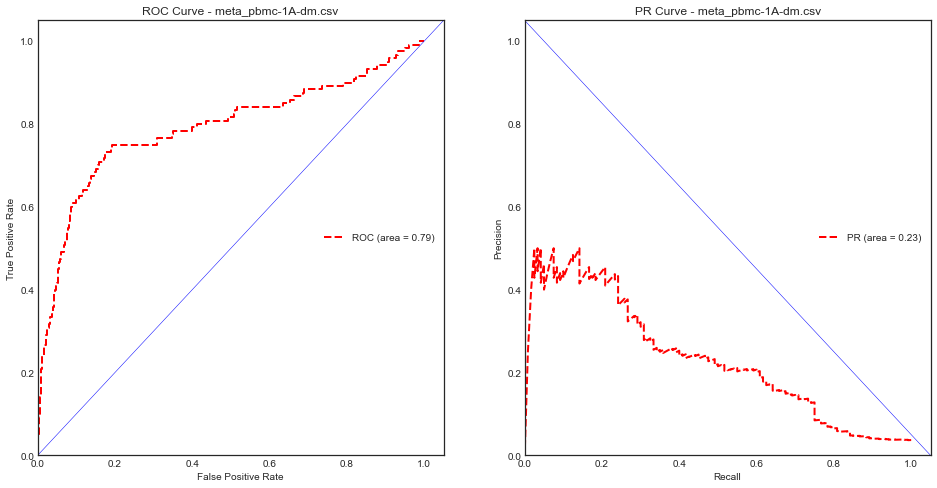

pbmc-1B-dm.csv --- meta_pbmc-1B-dm.csv
Before filter genes:  (3790, 15143)
(15143,)
After filter genes:  (3790, 2000)
(3790, 2000) (3790, 2000) (3790, 12336)
(7,)
Now Running:  (3790, 2000)
('FINISH!!!---', 0.8)


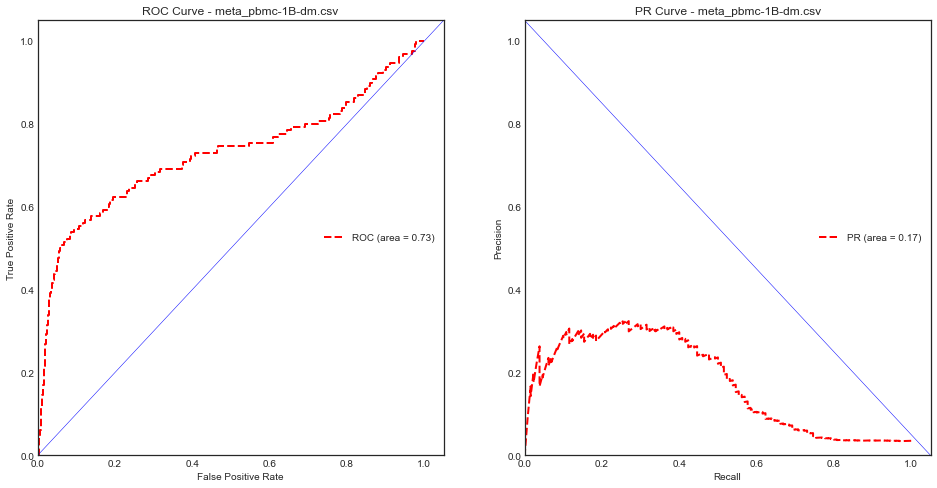

pbmc-1C-dm.csv --- meta_pbmc-1C-dm.csv
Before filter genes:  (5270, 15865)
(15865,)
After filter genes:  (5270, 2000)
(5270, 2000) (5270, 2000) (5270, 12972)
(7,)
Now Running:  (5270, 2000)
('FINISH!!!---', 0.8)


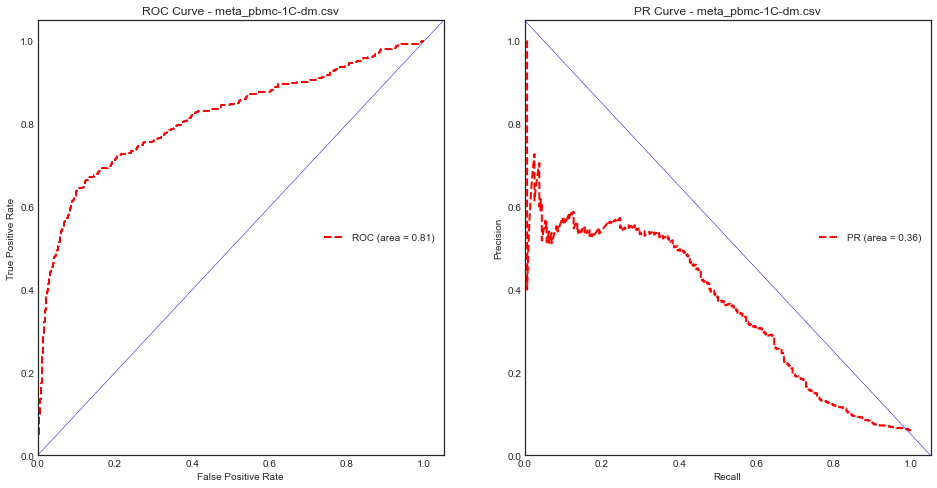

pbmc-2ctrl-dm.csv --- meta_pbmc-2ctrl-dm.csv
Before filter genes:  (13913, 17584)
(17584,)
After filter genes:  (13913, 2000)
(13913, 2000) (13913, 2000) (13913, 14862)
(11,)
Now Running:  (13913, 2000)
('FINISH!!!---', 0.8)


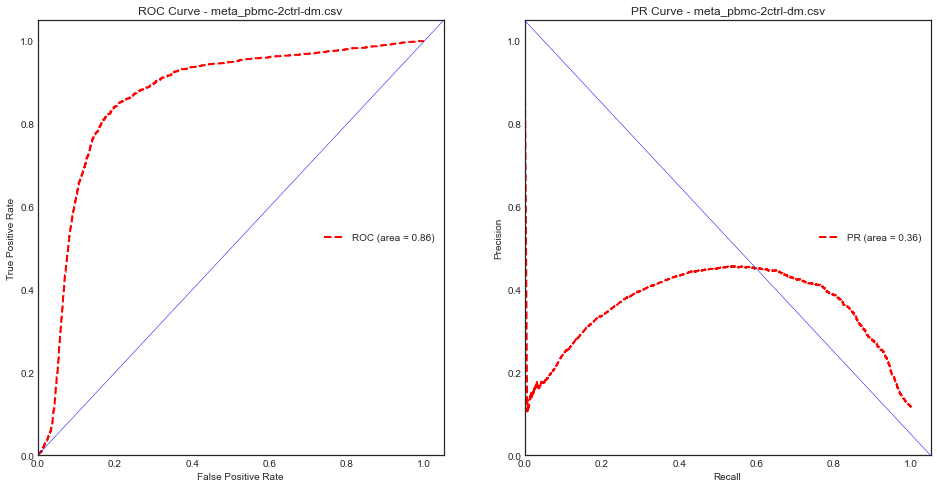

pbmc-2stim-dm.csv --- meta_pbmc-2stim-dm.csv
Before filter genes:  (13916, 17315)
(17315,)
After filter genes:  (13916, 2000)
(13916, 2000) (13916, 2000) (13916, 14640)
(11,)
Now Running:  (13916, 2000)
('FINISH!!!---', 0.8)


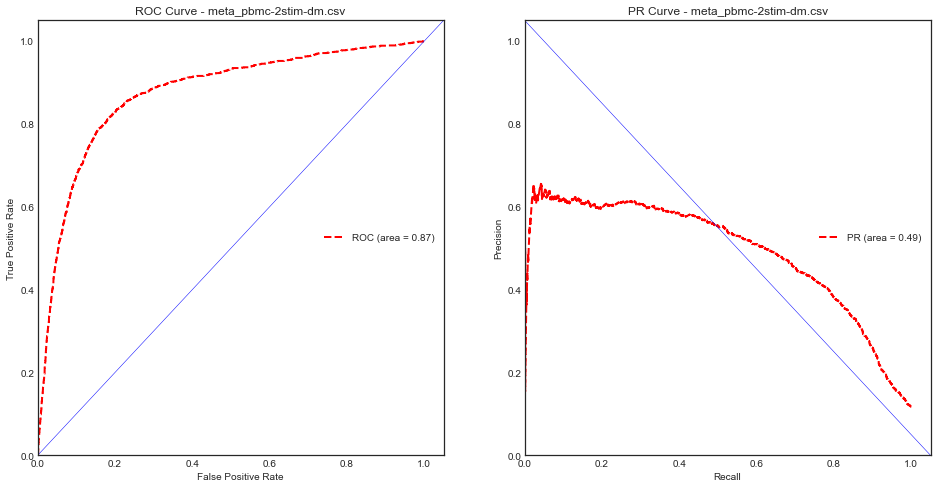

In [167]:
import rpy2.robjects as robjects

root_dir = '../datasets/real_datasets/'
def roc_pr_plot(y_label, y_pre ,path=None, title=None):
    precision, recall, thresholds_pr = precision_recall_curve(y_label, y_pre)
    fpr, tpr, thersholds_roc = roc_curve(y_label, y_pre, pos_label=1)
    pr_auc = auc(recall, precision)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(fpr, tpr, 'r--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
     
    ax.set_xlim([0, 1.05])  
    ax.set_ylim([0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve - {}'.format(title))
    ax.legend(loc="center right")
    ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='-',c='b', lw=0.5)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(recall, precision, 'r--', label='PR (area = {0:.2f})'.format(pr_auc), lw=2)
     
    ax2.set_xlim([0, 1.05]) 
    ax2.set_ylim([0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')  
    ax2.set_title('PR Curve - {}'.format(title))
    ax2.legend(loc="center right")
    ax2.plot((0, 1), (1, 0), transform=ax2.transAxes, ls='-',c='b', lw=0.5)
    if path:
        fig.savefig(path)
def umap_preproc(matrix):
    adata = ad.AnnData(matrix)
    adata_filter_gene = ad.AnnData(matrix)
    print('Before filter genes: ', adata.shape)
    sc.pp.filter_genes(adata_filter_gene, min_cells=3)

    adata.raw = adata
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    print(adata.var.highly_variable.shape)
    idxs = adata.var.highly_variable
    adata = adata[:, adata.var.highly_variable]
    print('After filter genes: ', adata.shape)

    adata_hvg = adata.raw.to_adata()[:, idxs]
    sc.tl.pca(adata, svd_solver='arpack')

    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    print(adata.X.shape, adata_hvg.X.shape, adata_filter_gene.X.shape)
    return adata, adata_hvg, adata_filter_gene
#! Use raw count data to build simulated doublets
def generate_dbl_vector(ct1_idx, ct2_idx, num, mtx):
    a = np.random.choice(ct1_idx, num, replace=True)
    b = np.random.choice(ct2_idx, num, replace=True)
    rand_mtx1 = mtx[a]
    rand_mtx2 = mtx[b]
    sampled_dbl_mtx = (rand_mtx1+rand_mtx2)
    rand = np.random.rand(sampled_dbl_mtx.shape[0], sampled_dbl_mtx.shape[1]) - 0.5
    sampled_dbl_mtx = np.round(sampled_dbl_mtx + rand)
    return sampled_dbl_mtx
roc_collect = {}
prc_collect = {}
this_resolution = 0.8

for file in data_files:
    meta_name = 'meta_'+file
    print(file,'---' ,meta_name)
    simulated_data = sparse.load_npz(os.path.join(root_dir, file.split('.')[0]+'.npz')).todense()
    meta_data = pd.read_csv(os.path.join(root_dir, meta_name)).reset_index(drop=True)
    filtered, adata_hvg, adata_filter_gene = umap_preproc(simulated_data)
    sc.tl.leiden(filtered, resolution=this_resolution)
    leiden_lst = filtered.obs['leiden']
    print(np.unique(leiden_lst).shape)

    for name, this_mtx in {'hvg_gene': adata_hvg}.items():
        np_array_transform = np.array(this_mtx.X)
        print('Now Running: ', np_array_transform.shape)
        search_lst = leiden_lst

        matrix = np_array_transform
        ct_idx = {}
        # create index dict for each cell type
        for ct in np.unique(search_lst):
            ct_idx[ct] = search_lst[search_lst == ct].index

        # pre_compute sgl theta and miu
        nb_sgl_param_dict = {}
        for this_ct, this_idx in ct_idx.items():
            this_mtx = np.array(matrix)[[int(i) for i in this_idx]]
            all_miu, all_var, all_theta = NB_pre(this_mtx)
            nb_sgl_param_dict[this_ct] = [all_miu, all_var, all_theta]

        # pre_compute dbl theta and miu
        doublet_ct_lst = None
        nb_dbl_param_dict = {}
        artificial_dbl_clt = np.array([])
        doublet_ct_lst = list(itertools.combinations(np.unique(search_lst), 2))
        for ct1, ct2 in doublet_ct_lst:
            ct1_dx, ct2_idx = [int(i) for i in ct_idx[ct1]], [int(i) for i in ct_idx[ct2]]
            artifitial_cmb_mtx = generate_dbl_vector(ct1_dx, ct2_idx, num=500, mtx = matrix)
            if artificial_dbl_clt.shape[0] == 0:
                artificial_dbl_clt = artifitial_cmb_mtx
            else:
                artificial_dbl_clt = np.vstack((artificial_dbl_clt, artifitial_cmb_mtx))
            cmb_miu, cmb_var, cmb_theta = NB_pre(artifitial_cmb_mtx)
            dbl_type = (ct1+'+'+ct2) if ((ct1) < (ct2)) else (ct2+'+'+ct1)
            nb_dbl_param_dict[dbl_type] = [cmb_miu, cmb_var, cmb_theta]

        whole_lst = list(nb_sgl_param_dict.keys()) + list(nb_dbl_param_dict.keys())
        scores_df_fast = pd.DataFrame(index=range(matrix.shape[0]))
        scores_artificial_dbl = pd.DataFrame(index=range(artificial_dbl_clt.shape[0]))

        for sgl, sgl_param in nb_sgl_param_dict.items():
            miu, var, theta = sgl_param
            this_score_all = NB_model(matrix, theta, miu)
            this_score =  np.mean(this_score_all, axis = 1)
            scores_df_fast[sgl] = this_score

            this_score_all_artificial = NB_model(artificial_dbl_clt, theta, miu)
            this_score_artificial =  np.mean(this_score_all_artificial, axis = 1)
            scores_artificial_dbl[sgl] = this_score_artificial

        for dbl, dbl_param in nb_dbl_param_dict.items():
            dbl_miu, dbl_var, dbl_theta = dbl_param
            this_score_all = (NB_model(matrix, dbl_theta, dbl_miu))
            this_score = np.mean(this_score_all, axis = 1)
            scores_df_fast[dbl] = this_score

            this_score_all_artificial = (NB_model(artificial_dbl_clt, dbl_theta, dbl_miu))
            this_score_artificial = np.mean(this_score_all_artificial, axis = 1)
            scores_artificial_dbl[dbl] = this_score_artificial

        #! New Approach
        combined_mtx = pd.concat((scores_df_fast, scores_artificial_dbl), axis=0)
        y_lables = [0]*scores_df_fast.shape[0]+[1]*scores_artificial_dbl.shape[0]

        #* Only for droplets
        sgl_n_real = np.unique(search_lst).shape[0]
        biggest_sgl_scores_real = scores_df_fast.iloc[:, :sgl_n].max(axis=1)
        biggest_dbl_scores_real = scores_df_fast.iloc[:, sgl_n:].max(axis=1)

        #* Droplet and artificial doublets
        sgl_n = np.unique(search_lst).shape[0]
        biggest_sgl_scores = combined_mtx.iloc[:, :sgl_n].max(axis=1)
        biggest_dbl_scores = combined_mtx.iloc[:, sgl_n:].max(axis=1)
        final_score = biggest_dbl_scores - biggest_sgl_scores
        #* 57 feature
        combined_mtx['bg_dbl'] = biggest_dbl_scores
        combined_mtx['bg_sgl'] = biggest_sgl_scores
        clf= MLPClassifier(random_state=1, max_iter=300).fit(combined_mtx, y_lables)

        rltss = clf.predict_proba(scores_df_fast)

        y_label = meta_data['x'].copy()
        y_label[y_label == 'doublet'] = 1
        y_label[y_label == 'singlet'] = 0
        y_label = [int(i) for i in y_label]

        y_pre = rltss[:, 1]
        precision, recall, thresholds_pr = precision_recall_curve(y_label, y_pre)
        fpr, tpr, thersholds_roc = roc_curve(y_label, y_pre, pos_label=1)
        pr_auc = auc(recall, precision)
        roc_auc = auc(fpr, tpr)
        roc_collect[file.split('.')[0]] = roc_auc
        prc_collect[file.split('.')[0]] = pr_auc
        roc_pr_plot(y_label=y_label, y_pre=rltss[:, 1], title=meta_name)
        print(('FINISH!!!---', this_resolution))
        plt.show()

# scMODO with Combined Feature from scDblFinder

REAL
pbmc-1C-dm.csv --- meta_pbmc-1C-dm.csv
Before filter genes:  (5270, 15865)
filtered out 2893 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
(15865,)
After filter genes:  (5270, 2000)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
(5270, 2000) (5270, 2000) (5270, 12972)
running Leiden cluster

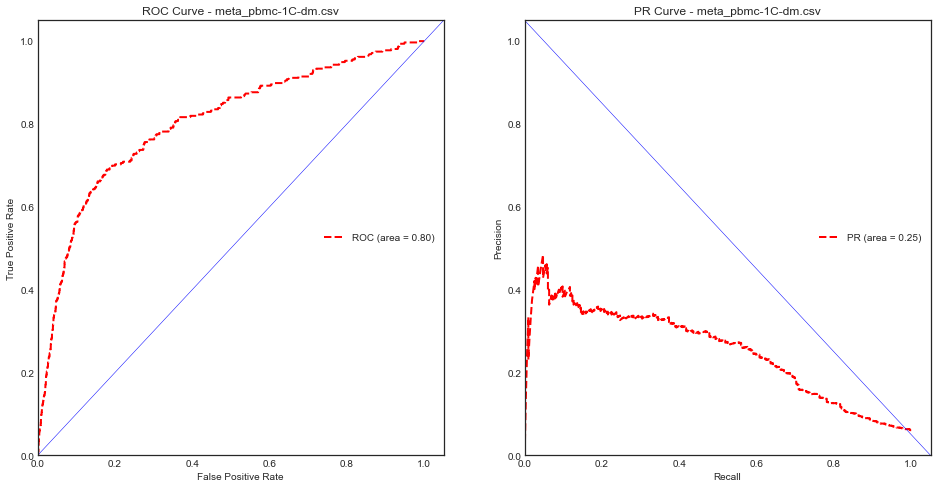

In [52]:
import rpy2.robjects as robjects

SOURCE = 'REAL'
if SOURCE == 'PBMC':
    root_dir = '../pbmc3k_filtered_gene_bc_matrices/simulated_pbmc/scanpy_sum/'
else:
    root_dir = '../datasets/real_datasets/'
def umap_preproc(matrix):
    adata = ad.AnnData(matrix)
    adata_filter_gene = ad.AnnData(matrix)
    print('Before filter genes: ', adata.shape)
    sc.pp.filter_genes(adata_filter_gene, min_cells=3)

    adata.raw = adata.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    print(adata.var.highly_variable.shape)
    idxs = adata.var.highly_variable
    adata = adata[:, adata.var.highly_variable]
    print('After filter genes: ', adata.shape)

    adata_hvg = adata.raw.to_adata()[:, idxs]
    sc.tl.pca(adata, svd_solver='arpack')

    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    print(adata.X.shape, adata_hvg.X.shape, adata_filter_gene.X.shape)
    return adata, adata_hvg, adata_filter_gene
#! Use raw count data to build simulated doublets
def generate_dbl_vector(ct1_idx, ct2_idx, num, mtx):
    a = np.random.choice(ct1_idx, num, replace=True)
    b = np.random.choice(ct2_idx, num, replace=True)
    rand_mtx1 = mtx[a]
    rand_mtx2 = mtx[b]
    sampled_dbl_mtx = (rand_mtx1+rand_mtx2)
    rand = np.random.rand(sampled_dbl_mtx.shape[0], sampled_dbl_mtx.shape[1]) - 0.5
    sampled_dbl_mtx = np.round(sampled_dbl_mtx + rand)
    return sampled_dbl_mtx
roc_collect = {}
prc_collect = {}
this_resolution = 0.8

for file in ['pbmc-1C-dm.csv']:
    print(SOURCE)
    if SOURCE == 'PBMC':
    #* PBMC
        meta_name = 'meta_bin_'+str(file)+'.csv'
        simulated_data = sparse.load_npz(os.path.join(root_dir, 'sc_data_'+str(file)+'.npz')).todense()
        meta_data = pd.read_csv(os.path.join(root_dir, meta_name)).reset_index(drop=True)
    else:
        meta_name = 'meta_'+file
        print(file,'---' ,meta_name)
        simulated_data = sparse.load_npz(os.path.join(root_dir, file.split('.')[0]+'.npz')).todense()
        meta_data = pd.read_csv(os.path.join(root_dir, meta_name)).reset_index(drop=True)
    filtered, adata_hvg, adata_filter_gene = umap_preproc(simulated_data)
    sc.tl.leiden(filtered, resolution=this_resolution)
    leiden_lst = filtered.obs['leiden']
    print(np.unique(leiden_lst).shape)

    for name, this_mtx in {'hvg_gene': adata_hvg}.items():
        np_array_transform = np.array(this_mtx.X)
        print('Now Running: ', np_array_transform.shape)
        search_lst = leiden_lst

        matrix = np_array_transform
        ct_idx = {}
        # create index dict for each cell type
        for ct in np.unique(search_lst):
            ct_idx[ct] = search_lst[search_lst == ct].index

        # pre_compute sgl theta and miu
        nb_sgl_param_dict = {}
        for this_ct, this_idx in ct_idx.items():
            this_mtx = np.array(matrix)[[int(i) for i in this_idx]]
            all_miu, all_var, all_theta = NB_pre(this_mtx)
            nb_sgl_param_dict[this_ct] = [all_miu, all_var, all_theta]

        # pre_compute dbl theta and miu
        doublet_ct_lst = None
        nb_dbl_param_dict = {}
        artificial_dbl_clt = np.array([])
        doublet_ct_lst = list(itertools.combinations(np.unique(search_lst), 2))
        for ct1, ct2 in doublet_ct_lst:
            ct1_dx, ct2_idx = [int(i) for i in ct_idx[ct1]], [int(i) for i in ct_idx[ct2]]
            artifitial_cmb_mtx = generate_dbl_vector(ct1_dx, ct2_idx, num=500, mtx = matrix)
            if artificial_dbl_clt.shape[0] == 0:
                artificial_dbl_clt = artifitial_cmb_mtx
            else:
                artificial_dbl_clt = np.vstack((artificial_dbl_clt, artifitial_cmb_mtx))
            cmb_miu, cmb_var, cmb_theta = NB_pre(artifitial_cmb_mtx)
            dbl_type = (ct1+'+'+ct2) if ((ct1) < (ct2)) else (ct2+'+'+ct1)
            nb_dbl_param_dict[dbl_type] = [cmb_miu, cmb_var, cmb_theta] 

        whole_lst = list(nb_sgl_param_dict.keys()) + list(nb_dbl_param_dict.keys())
        scores_df_fast = pd.DataFrame(index=range(matrix.shape[0]))
        scores_artificial_dbl = pd.DataFrame(index=range(artificial_dbl_clt.shape[0]))

        for sgl, sgl_param in nb_sgl_param_dict.items():
            miu, var, theta = sgl_param
            this_score_all = NB_model(matrix, theta, miu)
            this_score =  np.mean(this_score_all, axis = 1)
            scores_df_fast[sgl] = this_score

            this_score_all_artificial = NB_model(artificial_dbl_clt, theta, miu)
            this_score_artificial =  np.mean(this_score_all_artificial, axis = 1)
            scores_artificial_dbl[sgl] = this_score_artificial

        for dbl, dbl_param in nb_dbl_param_dict.items():
            dbl_miu, dbl_var, dbl_theta = dbl_param
            this_score_all = (NB_model(matrix, dbl_theta, dbl_miu))
            this_score = np.mean(this_score_all, axis = 1)
            scores_df_fast[dbl] = this_score

            this_score_all_artificial = (NB_model(artificial_dbl_clt, dbl_theta, dbl_miu))
            this_score_artificial = np.mean(this_score_all_artificial, axis = 1)
            scores_artificial_dbl[dbl] = this_score_artificial

        #! New Approach
        combined_mtx = pd.concat((scores_df_fast, scores_artificial_dbl), axis=0)
        y_lables = [0]*scores_df_fast.shape[0]+[1]*scores_artificial_dbl.shape[0]
        real_arti_mtx = np.concatenate((matrix, artificial_dbl_clt), axis=0).T

        %R -i real_arti_mtx
        %R sce <- SingleCellExperiment(list(counts = real_arti_mtx))
        %R sce1 <- scDblFinder(sce, returnType = 'table')
        return_r_df = robjects.r("sce1[which(sce1$type == 'real'), ]")
        cy_return_r_df = return_r_df.copy()
        cy_return_r_df = cy_return_r_df.drop(['type', 'src', 'class', 'include.in.training', 'nearestClass', 'score'], axis=1)
        cy_return_r_df = (cy_return_r_df-cy_return_r_df.min())/(cy_return_r_df.max() - cy_return_r_df.min())
        cy_return_r_df = cy_return_r_df.reset_index().drop(['index'], axis=1)
        cmb_feature_mtx = pd.concat([cy_return_r_df.reset_index(), combined_mtx.reset_index()], ignore_index=True, axis=1).drop([0], axis=1)
        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=0).fit(cmb_feature_mtx, y_lables)

        pred_mtx = cmb_feature_mtx.iloc[:scores_df_fast.shape[0], :]
        rltss = clf.predict_proba(pred_mtx)
        y_label = meta_data['x'].copy()
        y_label[y_label == 'doublet'] = 1
        y_label[y_label == 'singlet'] = 0
        y_label = [int(i) for i in y_label]
        y_pre = rltss[:, 1]

        pd.DataFrame({'score':y_pre}).to_csv('../results_sim_dataset/sum_pbmc/feature_55+15/gdbt0.1_rlt_{}_{}_reslt.csv'.format(file, this_resolution))

        roc_pr_plot(y_label=y_label, y_pre=rltss[:, 1], title=meta_name)
        print(('FINISH!!!---', this_resolution))
        plt.show()

# scMODO with ZINB

In [ ]:
import rpy2.robjects as robjects
save_path = '../results_sim_dataset/sum_pbmc/classifier_55/' # The path to save computed doublet scores
SOURCE = 'PBMC'
if SOURCE == 'PBMC':
    root_dir = '../pbmc3k_filtered_gene_bc_matrices/simulated_pbmc/scanpy_sum/'
else:
    root_dir = '../datasets/real_datasets/'
def roc_pr_plot(y_label, y_pre ,path=None, title=None):
    precision, recall, thresholds_pr = precision_recall_curve(y_label, y_pre)
    fpr, tpr, thersholds_roc = roc_curve(y_label, y_pre, pos_label=1)
    pr_auc = auc(recall, precision)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(fpr, tpr, 'r--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
     
    ax.set_xlim([0, 1.05])  
    ax.set_ylim([0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve - {}'.format(title))
    ax.legend(loc="center right")
    ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='-',c='b', lw=0.5)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(recall, precision, 'r--', label='PR (area = {0:.2f})'.format(pr_auc), lw=2)
     
    ax2.set_xlim([0, 1.05]) 
    ax2.set_ylim([0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')  
    ax2.set_title('PR Curve - {}'.format(title))
    ax2.legend(loc="center right")
    ax2.plot((0, 1), (1, 0), transform=ax2.transAxes, ls='-',c='b', lw=0.5)
    if path:
        fig.savefig(path)
def umap_preproc(matrix):
    adata = ad.AnnData(matrix)
    adata_filter_gene = ad.AnnData(matrix)
    print('Before filter genes: ', adata.shape)
    sc.pp.filter_genes(adata_filter_gene, min_cells=3)

    adata.raw = adata
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    print(adata.var.highly_variable.shape)
    idxs = adata.var.highly_variable
    adata = adata[:, adata.var.highly_variable]
    print('After filter genes: ', adata.shape)

    adata_hvg = adata.raw.to_adata()[:, idxs]
    sc.tl.pca(adata, svd_solver='arpack')

    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    print(adata.X.shape, adata_hvg.X.shape, adata_filter_gene.X.shape)
    return adata, adata_hvg, adata_filter_gene
#! Use raw count data to build simulated doublets
def generate_dbl_vector(ct1_idx, ct2_idx, num, mtx):
    a = np.random.choice(ct1_idx, num, replace=True)
    b = np.random.choice(ct2_idx, num, replace=True)
    rand_mtx1 = mtx[a]
    rand_mtx2 = mtx[b]
    sampled_dbl_mtx = (rand_mtx1+rand_mtx2)
    rand = np.random.rand(sampled_dbl_mtx.shape[0], sampled_dbl_mtx.shape[1]) - 0.5
    sampled_dbl_mtx = np.round(sampled_dbl_mtx + rand)
    return sampled_dbl_mtx
roc_collect = {}
prc_collect = {}
this_resolution = 0.8

for file in range(2, 42, 2):
    if SOURCE == 'PBMC':
    #* PBMC
        meta_name = 'meta_bin_'+str(file)+'.csv'
        simulated_data = sparse.load_npz(os.path.join(root_dir, 'sc_data_'+str(file)+'.npz')).todense()
        meta_data = pd.read_csv(os.path.join(root_dir, meta_name)).reset_index(drop=True)
    else:
        meta_name = 'meta_'+file
        print(file,'---' ,meta_name)
        simulated_data = sparse.load_npz(os.path.join(root_dir, file.split('.')[0]+'.npz')).todense()
        meta_data = pd.read_csv(os.path.join(root_dir, meta_name)).reset_index(drop=True)
    filtered, adata_hvg, adata_filter_gene = umap_preproc(simulated_data)
    filtered, adata_hvg, adata_filter_gene = umap_preproc(simulated_data)
    sc.tl.leiden(filtered, resolution=this_resolution)
    leiden_lst = filtered.obs['leiden']
    print(np.unique(leiden_lst).shape)

    for name, this_mtx in {'hvg_gene': adata_hvg}.items():
        np_array_transform = np.array(this_mtx.X)
        print('Now Running: ', np_array_transform.shape)
        search_lst = leiden_lst

        matrix = np_array_transform
        ct_idx = {}
        # create index dict for each cell type
        for ct in np.unique(search_lst):
            ct_idx[ct] = search_lst[search_lst == ct].index

        # pre_compute sgl theta and miu
        nb_sgl_param_dict = {}
        for this_ct, this_idx in ct_idx.items():
            this_mtx = np.array(matrix)[[int(i) for i in this_idx]]
            all_miu, all_theta, all_pi = ZINB_pre(this_mtx)
            nb_sgl_param_dict[this_ct] = [all_miu, all_theta, all_pi]

        # pre_compute dbl theta and miu
        doublet_ct_lst = None
        nb_dbl_param_dict = {}
        artificial_dbl_clt = np.array([])
        doublet_ct_lst = list(itertools.combinations(np.unique(search_lst), 2))
        for ct1, ct2 in doublet_ct_lst:
            ct1_dx, ct2_idx = [int(i) for i in ct_idx[ct1]], [int(i) for i in ct_idx[ct2]]
            artifitial_cmb_mtx = generate_dbl_vector(ct1_dx, ct2_idx, num=500, mtx = matrix)
            if artificial_dbl_clt.shape[0] == 0:
                artificial_dbl_clt = artifitial_cmb_mtx
            else:
                artificial_dbl_clt = np.vstack((artificial_dbl_clt, artifitial_cmb_mtx))
            cmb_miu, cmb_theta, cmb_pi = ZINB_pre(artifitial_cmb_mtx)
            dbl_type = (ct1+'+'+ct2) if ((ct1) < (ct2)) else (ct2+'+'+ct1)
            nb_dbl_param_dict[dbl_type] = [cmb_miu, cmb_theta, cmb_pi]  

        whole_lst = list(nb_sgl_param_dict.keys()) + list(nb_dbl_param_dict.keys())
        scores_df_fast = pd.DataFrame(index=range(matrix.shape[0]))
        scores_artificial_dbl = pd.DataFrame(index=range(artificial_dbl_clt.shape[0]))

        for sgl, sgl_param in nb_sgl_param_dict.items():
            miu, theta, pi = sgl_param
            this_score_all = ZINB_model(matrix, theta, miu, pi)
            this_score =  np.mean(this_score_all, axis = 1)
            scores_df_fast[sgl] = this_score

            this_score_all_artificial = ZINB_model(artificial_dbl_clt, theta, miu, pi)
            this_score_artificial =  np.mean(this_score_all_artificial, axis = 1)
            scores_artificial_dbl[sgl] = this_score_artificial

        for dbl, dbl_param in nb_dbl_param_dict.items():
            dbl_miu, dbl_theta, dbl_pi = dbl_param
            this_score_all = ZINB_model(matrix, dbl_theta, dbl_miu, dbl_pi)
            this_score = np.mean(this_score_all, axis = 1)
            scores_df_fast[dbl] = this_score

            this_score_all_artificial = ZINB_model(artificial_dbl_clt, dbl_theta, dbl_miu, dbl_pi)
            this_score_artificial = np.mean(this_score_all_artificial, axis = 1)
            scores_artificial_dbl[dbl] = this_score_artificial

        #! New Approach
        combined_mtx = pd.concat((scores_df_fast, scores_artificial_dbl), axis=0)
        y_lables = [0]*scores_df_fast.shape[0]+[1]*scores_artificial_dbl.shape[0]

        #* Only for droplets
        sgl_n_real = np.unique(search_lst).shape[0]
        biggest_sgl_scores_real = scores_df_fast.iloc[:, :sgl_n_real].max(axis=1)
        biggest_dbl_scores_real = scores_df_fast.iloc[:, sgl_n_real:].max(axis=1)

        #* Droplet and artificial doublets
        sgl_n = np.unique(search_lst).shape[0]
        biggest_sgl_scores = combined_mtx.iloc[:, :sgl_n].max(axis=1)
        biggest_dbl_scores = combined_mtx.iloc[:, sgl_n:].max(axis=1)
        final_score = biggest_dbl_scores - biggest_sgl_scores
        
        clf= MLPClassifier(random_state=1, max_iter=300).fit(combined_mtx, y_lables)

        rltss = clf.predict_proba(scores_df_fast)
        if SOURCE == 'PBMC':
            y_label = meta_data['0'].copy()
        else:
            y_label = meta_data['x'].copy()
        y_label[y_label == 'doublet'] = 1
        y_label[y_label == 'singlet'] = 0
        y_label = [int(i) for i in y_label]

        y_pre = rltss[:, 1]
        precision, recall, thresholds_pr = precision_recall_curve(y_label, y_pre)
        fpr, tpr, thersholds_roc = roc_curve(y_label, y_pre, pos_label=1)
        pr_auc = auc(recall, precision)
        roc_auc = auc(fpr, tpr)
        roc_collect[file] = roc_auc

        prc_collect[file] = pr_auc
        pd.DataFrame({'score':y_pre}).to_csv(save_path + 'mlp_rlt_{}_{}_reslt.csv'.format(file, this_resolution))
        roc_pr_plot(y_label=y_label, y_pre=rltss[:, 1], title=meta_name)
        print(('FINISH!!!---', this_resolution))